In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'input_data':
                              {'input_draw_number': 29,
                              },
                          'randomness':
                              {'random_seed': 10,
                              },
                          'population':
                              {'population_size': 10_000,
                              },
                          'population':
                              {'age_start': 75,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-05-05 10:24:13.213 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-05-05 10:24:13.343 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-05-05 10:24:13.345 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 29'].
2023-05-05 10:24:13.350 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-05-05 10:24:13.906 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-05-05 10:24:13.906 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-05-05 10:24:14.268 | DEBUG    | vivarium

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,alive,age,entrance_time,location,sex,exit_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,polypill,lifestyle_adherence,ldlc_multiplier,sbp_medication,ldlc_medication_adherence,lifestyle,outreach,visit_type,last_fpg_test_date,scheduled_date
0,True,alive,81.699815,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat2,True,1.0,one_drug_half_dose_efficacy,cat2,NaT,cat2,none,2019-01-14 12:39:14.292583632,NaT
1,True,alive,85.170378,2020-12-04,Alabama,Female,NaT,not_dead,0.0,0.0,...,cat2,False,1.0,two_drug_half_dose_efficacy,cat3,NaT,cat2,none,2020-06-29 03:09:00.051485710,NaT
2,True,alive,80.191594,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat2,True,1.0,no_treatment,cat3,NaT,cat2,none,NaT,NaT
3,True,alive,76.731164,2020-12-04,Alabama,Female,NaT,not_dead,0.0,0.0,...,cat2,True,1.0,one_drug_half_dose_efficacy,cat3,NaT,cat2,none,NaT,NaT
4,True,alive,84.021498,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat2,False,1.0,no_treatment,cat3,NaT,cat2,none,NaT,2021-02-17 05:13:45.194102400


In [6]:
pop0.columns

Index(['tracked', 'age', 'location', 'alive', 'entrance_time', 'sex',
       'exit_time', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_st

In [7]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'lifestyle.propensity',
 'lifestyle.exposure',
 'risk_factor.lifestyle.exposure_parameters',
 'risk_factor.lifestyle.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardia

In [5]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   #sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   #sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   #sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                  ], axis=1)
data1.head()

,tracked,alive,age,entrance_time,location,sex,exit_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_medication_adherence,lifestyle,outreach,visit_type,last_fpg_test_date,scheduled_date,high_ldl,high_sbp,high_bmi,high_fpg
0,True,alive,81.699815,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat2,NaT,cat2,none,2019-01-14 12:39:14.292583632,NaT,3.525499,201.200000,35.481687,6.324880
1,True,alive,85.170378,2020-12-04,Alabama,Female,NaT,not_dead,0.0,0.0,...,cat3,NaT,cat2,none,2020-06-29 03:09:00.051485710,NaT,1.746258,134.426556,39.974506,5.641706
2,True,alive,80.191594,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat3,NaT,cat2,none,NaT,NaT,2.210092,144.689863,24.538654,6.919137
3,True,alive,76.731164,2020-12-04,Alabama,Female,NaT,not_dead,0.0,0.0,...,cat3,NaT,cat2,none,NaT,NaT,3.499379,167.970271,21.831321,7.268928
4,True,alive,84.021498,2020-12-04,Alabama,Male,NaT,not_dead,0.0,0.0,...,cat3,NaT,cat2,none,NaT,2021-02-17 05:13:45.194102400,2.460879,140.231488,27.544466,6.061621


In [6]:
1-(len(data1.loc[(data1.alive == 'alive') & (data1.ldlc_medication == 'no_treatment')])/len(data1.loc[(data1.alive == 'alive')]))

0.47706000000000004

In [7]:
data1.loc[data1.sex=='Female'].high_ldl.median()

2.7795691047980267

In [8]:
data1.loc[data1.sex=='Male'].high_ldl.median()

2.4559542575314346

In [9]:
sim_data = pd.DataFrame()
for step in list(range(0,10)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl')],
                   #sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   #sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   #sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   #sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   #sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity')],                       
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

2023-05-05 10:25:34.549 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-01 00:00:00
2023-05-05 10:26:50.898 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-29 00:00:00
2023-05-05 10:28:07.569 | DEBUG    | vivarium.framework.engine:step:172 - 2021-02-26 00:00:00
2023-05-05 10:29:25.025 | DEBUG    | vivarium.framework.engine:step:172 - 2021-03-26 00:00:00
2023-05-05 10:30:41.337 | DEBUG    | vivarium.framework.engine:step:172 - 2021-04-23 00:00:00
2023-05-05 10:31:56.273 | DEBUG    | vivarium.framework.engine:step:172 - 2021-05-21 00:00:00
2023-05-05 10:33:11.178 | DEBUG    | vivarium.framework.engine:step:172 - 2021-06-18 00:00:00
2023-05-05 10:34:26.229 | DEBUG    | vivarium.framework.engine:step:172 - 2021-07-16 00:00:00
2023-05-05 10:35:40.520 | DEBUG    | vivarium.framework.engine:step:172 - 2021-08-13 00:00:00
2023-05-05 10:36:55.180 | DEBUG    | vivarium.framework.engine:step:172 - 2021-09-10 00:00:00


In [10]:
meds = (sim_data
                .groupby(['step', 'sex','ldlc_medication'])
                .alive.count()
                .reset_index())
meds

,step,sex,ldlc_medication,alive
0,0,Female,high_intensity,1885
1,0,Female,high_with_eze,272
2,0,Female,low_intensity,5113
3,0,Female,low_med_with_eze,907
4,0,Female,medium_intensity,5720
...,...,...,...,...
115,9,Male,high_with_eze,2155
116,9,Male,low_intensity,3617
117,9,Male,low_med_with_eze,1253
118,9,Male,medium_intensity,1780


In [11]:
meds.loc[(meds.ldlc_medication=='no_treatment') & (meds.sex == 'Male') & (meds.step == 0)].alive

11    10010
Name: alive, dtype: int64

In [16]:
meds.loc[(meds.sex == 'Male') & (meds.step == 0)].alive.sum()

20194

In [17]:
10010/20194

0.49569178964048727

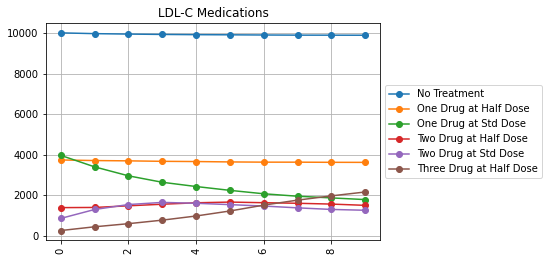

In [13]:
no_trt = meds.loc[(meds.ldlc_medication=='no_treatment') & (meds.sex == 'Male')]
plt.plot(no_trt['step'], no_trt['alive'], marker='o')
low = meds.loc[(meds.ldlc_medication=='low_intensity') & (meds.sex == 'Male')]
plt.plot(low['step'], low['alive'], marker='o')
medium = meds.loc[(meds.ldlc_medication=='medium_intensity') & (meds.sex == 'Male')]
plt.plot(medium['step'], medium['alive'], marker='o')
high = meds.loc[(meds.ldlc_medication=='high_intensity') & (meds.sex == 'Male')]
plt.plot(high['step'], high['alive'], marker='o')
low_eze = meds.loc[(meds.ldlc_medication=='low_med_with_eze') & (meds.sex == 'Male')]
plt.plot(low_eze['step'], low_eze['alive'], marker='o')
high_eze = meds.loc[(meds.ldlc_medication=='high_with_eze') & (meds.sex == 'Male')]
plt.plot(high_eze['step'], high_eze['alive'], marker='o')
plt.title(f'LDL-C Medications') 
plt.xticks(rotation=90)
plt.legend(['No Treatment', 'One Drug at Half Dose', 'One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose', 'Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

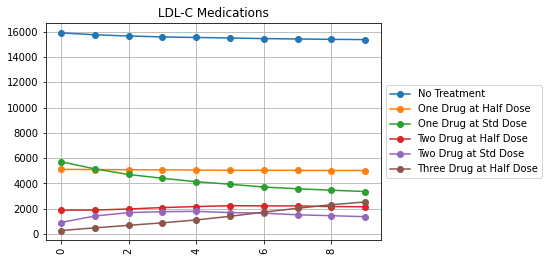

In [14]:
no_trt = meds.loc[(meds.ldlc_medication=='no_treatment') & (meds.sex == 'Female')]
plt.plot(no_trt['step'], no_trt['alive'], marker='o')
low = meds.loc[(meds.ldlc_medication=='low_intensity') & (meds.sex == 'Female')]
plt.plot(low['step'], low['alive'], marker='o')
medium = meds.loc[(meds.ldlc_medication=='medium_intensity') & (meds.sex == 'Female')]
plt.plot(medium['step'], medium['alive'], marker='o')
high = meds.loc[(meds.ldlc_medication=='high_intensity') & (meds.sex == 'Female')]
plt.plot(high['step'], high['alive'], marker='o')
low_eze = meds.loc[(meds.ldlc_medication=='low_med_with_eze') & (meds.sex == 'Female')]
plt.plot(low_eze['step'], low_eze['alive'], marker='o')
high_eze = meds.loc[(meds.ldlc_medication=='high_with_eze') & (meds.sex == 'Female')]
plt.plot(high_eze['step'], high_eze['alive'], marker='o')
plt.title(f'LDL-C Medications') 
plt.xticks(rotation=90)
plt.legend(['No Treatment', 'One Drug at Half Dose', 'One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose', 'Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

In [38]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

<AxesSubplot:xlabel='high_sbp', ylabel='Count'>

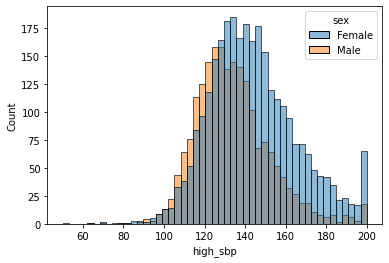

In [39]:
import seaborn as sns
sns.histplot(data=data1, x='high_sbp', hue='sex')

In [42]:
sbp_art = art.load('risk_factor.high_systolic_blood_pressure.exposure')
sbp_art
#plt.hist(sbp_art.high_sbp, bins=25)

draw_0  \
sex    age_start age_end year_start year_end parameter                
Female 25.0      30.0    2019       2020     continuous  109.839770   
       30.0      35.0    2019       2020     continuous  114.038764   
       35.0      40.0    2019       2020     continuous  115.260806   
       40.0      45.0    2019       2020     continuous  120.694393   
       45.0      50.0    2019       2020     continuous  123.815329   
       50.0      55.0    2019       2020     continuous  121.996811   
       55.0      60.0    2019       2020     continuous  128.307212   
       60.0      65.0    2019       2020     continuous  126.073248   
       65.0      70.0    2019       2020     continuous  135.451556   
       70.0      75.0    2019       2020     continuous  134.218457   
       75.0      80.0    2019       2020     continuous  141.340695   
       80.0      85.0    2019       2020     continuous  146.529839   
       85.0      90.0    2019       2020     continuous  145.469374   
       90.0      95.0    2019       2020     continuous  142.901310   
       95.0      125.0   2019       2020     continuous  141.815610   
Male   25.0      30.0    2019       2020     continuous  114.610295   
       30.0      35.0    2019       2020     continuous  120.604958   
       35.0      40.0    2019       2020     continuous  127.693264   
       40.0      45.0    2019       2020     continuous  125.517558   
       45.0      50.0    2019       2020     continuous  126.149041   
       50.0      55.0    2019       2020     continuous  129.842556   
       55.0      60.0    2019       2020     continuous  127.935990   
       60.0      65.0    2019       2020     continuous  131.650811   
       65.0      70.0    2019       2020     continuous  131.234998   
       70.0      75.0    2019       2020     continuous  128.406278   
       75.0      80.0    2019       2020     continuous  131.865846   
       80.0      85.0    2019       2020     continuous  134.100913   
       85.0      90.0    2019       2020     continuous  136.909797   
       90.0      95.0    2019       2020     continuous  137.908513   
       95.0      125.0   2019       2020     continuous  139.698289   

                                                             draw_1  \
sex    age_start age_end year_start year_end parameter                
Female 25.0      30.0    2019       2020     continuous  110.132984   
       30.0      35.0    2019       2020     continuous  114.288067   
       35.0      40.0    2019       2020     continuous  114.821917   
       40.0      45.0    2019       2020     continuous  118.053402   
       45.0      50.0    2019       2020     continuous  120.648639   
       50.0      55.0    2019       2020     continuous  126.863421   
       55.0      60.0    2019       2020     continuous  127.132366   
       60.0      65.0    2019       2020     continuous  129.399526   
       65.0      70.0    2019       2020     continuous  130.090517   
       70.0      75.0    2019       2020     continuous  134.241689   
       75.0      80.0    2019       2020     continuous  139.929701   
       80.0      85.0    2019       2020     continuous  146.538635   
       85.0      90.0    2019       2020     continuous  142.405169   
       90.0      95.0    2019       2020     continuous  141.620256   
       95.0      125.0   2019       2020     continuous  144.673375   
Male   25.0      30.0    2019       2020     continuous  118.976671   
       30.0      35.0    2019       2020     continuous  121.036340   
       35.0      40.0    2019       2020     continuous  121.083393   
       40.0      45.0    2019       2020     continuous  122.640359   
       45.0      50.0    2019       2020     continuous  123.889806   
       50.0      55.0    2019       2020     continuous  128.197799   
       55.0      60.0    2019       2020     continuous  127.760400   
       60.0      65.0    2019       2020     continuous  131.942404   
       65.0  

## Testing Exposure Compared to Artifact in 2021

In [40]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

ls: cannot access '/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/': No such file or directory


In [41]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [42]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.35,0.975], axis=1).filter(['mean','35%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### SBP

In [43]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

/tmp/ipykernel_1411603/240823744.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,110.635893,110.098339,107.945700,113.550750,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,112.876275,112.329861,110.098198,115.523727,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,116.139886,115.590512,113.594023,118.770064,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,118.491616,117.983562,115.903577,121.039457,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,121.645391,121.090394,118.875235,124.529834,Alabama,exposure,45_to_49


In [44]:
sbp_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_sbp.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
sbp_exp = sbp_exp.loc[sbp_exp.age_start < 105]
sbp_exp.head()

,age_start,sex,mean,2.5%,97.5%
0,75.0,Female,141.869042,108.545969,189.902385
1,75.0,Male,132.288904,102.784837,178.300144
2,80.0,Female,146.802571,106.634932,199.980824
3,80.0,Male,133.997993,103.704276,178.314373
4,85.0,Female,143.816861,108.550544,193.272431


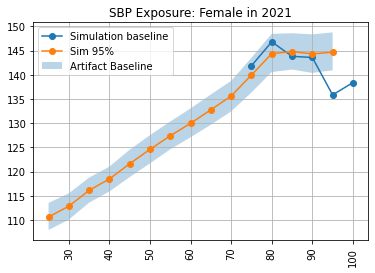

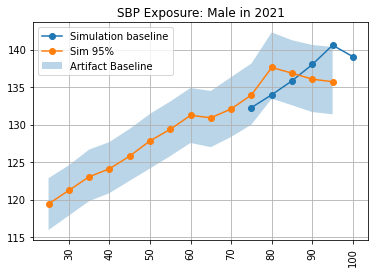

In [45]:
for sex in sbp_exp.sex.unique():
    plt.figure() 
    subdata = sbp_exp.loc[(sbp_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [18]:
data1.loc[data1.age_start > 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
4700,True,106.524522,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.328884,187.779511,23.861687,6.119356,0.005735,0.004658,0.002334,105.0
6575,True,108.032306,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,2021-02-14 12:33:06.970780800,none,2.808106,137.643584,31.466309,8.347287,0.013222,0.008608,0.007617,105.0


Looks like the ends of the graph is just due to there being only one person in those groups! I removed them for clarity

### LDL-C

In [100]:
ldl_art_all = art.load('risk_factor.high_ldl_cholesterol.exposure')
ldl_art_all = ldl_art_all.loc[ldl_art_all.index.get_level_values('age_start') > 70]
ldl_small = ldl_art_all.apply(pd.DataFrame.describe, percentiles=[0.65], axis=1).filter(['65%']).reset_index()
ldl_small.mean()

/tmp/ipykernel_923009/2109636798.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ldl_small.mean()


age_start       85.000000
age_end         95.000000
year_start    2019.000000
year_end      2020.000000
65%              2.910916
dtype: float64

In [89]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

/tmp/ipykernel_923009/795945589.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.639862,2.600945,2.472574,2.821188,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.724353,2.691550,2.553736,2.905134,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.802925,2.772667,2.639513,2.972487,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.880791,2.850118,2.721814,3.039119,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,2.998297,2.963904,2.837974,3.175367,Alabama,exposure,45_to_49


In [82]:
ldl_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_ldl.describe(percentiles=[.025, 0.35,.975])
                .filter(['mean','35%','2.5%','97.5%'])
                .reset_index())
ldl_exp

,age_start,sex,mean,35%,2.5%,97.5%
0,25.0,Female,2.620946,2.244025,1.051474,4.492790
1,25.0,Male,2.810904,2.365098,1.310526,4.687545
2,30.0,Female,2.702871,2.361349,1.158204,4.345764
3,30.0,Male,2.852065,2.519793,1.394397,4.602793
4,35.0,Female,2.769553,2.422764,1.289963,4.448486
5,35.0,Male,2.974062,2.657912,1.245755,4.996418
6,40.0,Female,2.750465,2.343496,1.177530,4.762312
7,40.0,Male,3.085771,2.727518,1.375213,4.957234
8,45.0,Female,2.950846,2.585639,1.405571,5.012120
9,45.0,Male,2.998687,2.604313,1.341587,4.884875


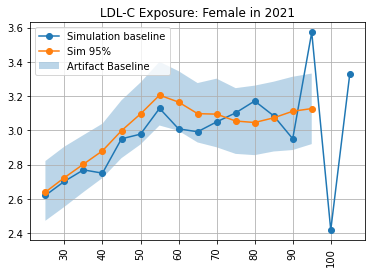

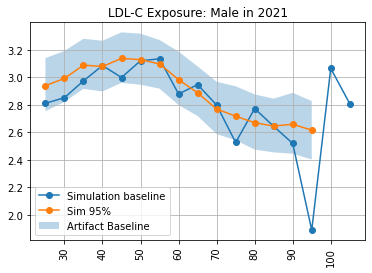

In [38]:
for sex in ldl_exp.sex.unique():
    plt.figure() 
    subdata = ldl_exp.loc[(ldl_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [22]:
data1.loc[data1.age_start == 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
2108,True,101.601737,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.806020,194.654956,28.820533,5.647478,0.006498,0.005278,0.002028,100.0
2285,True,104.867639,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.409409,131.617414,25.428487,9.634173,0.005316,0.004318,0.001913,100.0
4871,True,104.731512,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.022770,134.074676,30.117374,8.114999,0.012780,0.008320,0.005216,100.0
7436,True,100.593125,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,4.106867,129.441540,30.292312,6.212580,0.010671,0.006947,0.004901,100.0
7744,True,100.136283,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.881371,138.752634,20.549861,4.270128,0.004938,0.004010,0.000552,100.0
8042,True,104.439608,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.577250,138.738971,19.741234,5.641705,0.004938,0.004010,0.000462,100.0


Again, the issues at the end of the graph look like they are due to small samples

## BMI too

In [19]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

/tmp/ipykernel_32641/240823744.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,30.899912,30.834806,30.572156,31.233780,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,31.636913,31.572002,31.293987,31.989474,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,31.883495,31.819942,31.555235,32.210906,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,32.130649,32.065292,31.801051,32.462829,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,32.169931,32.101729,31.855765,32.505542,Alabama,exposure,45_to_49


In [21]:
bmi_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_bmi.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
bmi_exp = bmi_exp.loc[bmi_exp.age_start < 105]
bmi_exp.head()

,age_start,sex,mean,2.5%,97.5%
0,25.0,Female,30.429599,15.748353,50.808651
1,25.0,Male,29.119499,17.145312,47.206215
2,30.0,Female,31.624292,17.902438,53.565990
3,30.0,Male,30.305817,19.311306,46.005232
4,35.0,Female,31.437472,16.492798,52.796450


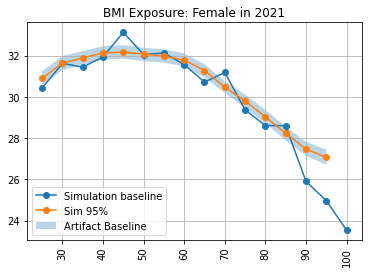

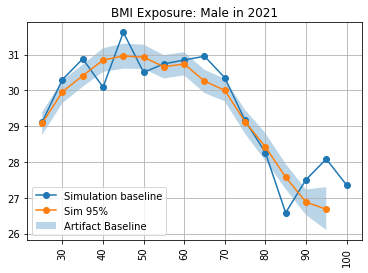

In [22]:
for sex in bmi_exp.sex.unique():
    plt.figure() 
    subdata = bmi_exp.loc[(bmi_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Testing for Medication Increases in SBP

In [53]:
sim_data = pd.DataFrame()
for step in list(range(0,75)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity')],                       
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

2023-04-20 11:23:25.596 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-01 00:00:00
2023-04-20 11:23:35.745 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-29 00:00:00
2023-04-20 11:23:45.341 | DEBUG    | vivarium.framework.engine:step:172 - 2021-02-26 00:00:00
2023-04-20 11:23:55.073 | DEBUG    | vivarium.framework.engine:step:172 - 2021-03-26 00:00:00
2023-04-20 11:24:04.749 | DEBUG    | vivarium.framework.engine:step:172 - 2021-04-23 00:00:00
2023-04-20 11:24:14.325 | DEBUG    | vivarium.framework.engine:step:172 - 2021-05-21 00:00:00
2023-04-20 11:24:23.956 | DEBUG    | vivarium.framework.engine:step:172 - 2021-06-18 00:00:00
2023-04-20 11:24:33.631 | DEBUG    | vivarium.framework.engine:step:172 - 2021-07-16 00:00:00
2023-04-20 11:24:43.332 | DEBUG    | vivarium.framework.engine:step:172 - 2021-08-13 00:00:00
2023-04-20 11:24:52.794 | DEBUG    | vivarium.framework.engine:step:172 - 2021-09-10 00:00:00
2023-04-20 11:25:02.403 | DEBUG    | vivarium.framework.engi

In [57]:
sbp.step.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74])

In [55]:
data_all = sim_data.loc[(sim_data.age > 25) & (sim_data.alive == 'alive')]
data_all['age_start'] = ((data_all.age/5).astype(int) * 5).astype(float)
#data_all['sbp_med_short'] = np.where(data_all.sbp_medication == 'no_treatment', 'none',np.where(data_all.sbp_medication == 'one_drug_half_dose_efficacy', 'one_half',np.where(data_all.sbp_medication == 'one_drug_std_dose_efficacy','one_std', np.where(data_all.sbp_medication == 'two_drug_half_dose_efficacy', 'two_half', np.where(data_all.sbp_medication == 'two_drug_std_dose_efficacy', 'two_std',np.where(data_all.sbp_medication == 'three_drug_half_dose_efficacy','three_half','three_std'))))))
data_all.head()

,tracked,age,entrance_time,exit_time,alive,sex,location,years_of_life_lost,cause_of_death,years_lived_with_disability,...,heart_failure_residual_event_time,heart_failure_residual_event_count,high_ldl,high_sbp,high_bmi,bmi_propensity,high_fpg,sbp_propensity,step,age_start
0,True,81.776475,2020-12-04,NaT,alive,Male,Alabama,0.0,not_dead,0.000000,...,NaT,0,3.525499,200.000000,35.481687,0.911852,6.324880,0.985074,0,80.0
1,True,85.247038,2020-12-04,NaT,alive,Female,Alabama,0.0,not_dead,0.000000,...,NaT,0,1.746258,131.898711,39.974506,0.951787,5.641706,0.277400,0,85.0
2,True,80.268254,2020-12-04,NaT,alive,Male,Alabama,0.0,not_dead,0.000000,...,NaT,0,2.210092,144.689863,24.538654,0.229894,6.919137,0.596934,0,80.0
3,True,76.807824,2020-12-04,NaT,alive,Female,Alabama,0.0,not_dead,0.000000,...,NaT,0,3.499379,167.970271,21.831321,0.135209,7.268928,0.896922,0,75.0
4,True,84.098158,2020-12-04,NaT,alive,Male,Alabama,0.0,not_dead,0.019745,...,NaT,0,2.460879,140.231488,27.544466,0.466085,6.061621,0.509142,0,80.0


In [56]:
sbp = data_all.groupby(['age_start','sex','step']).high_sbp.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
sbp

,age_start,sex,step,mean,2.5%,97.5%
0,75.0,Female,0,140.999938,106.679330,188.572791
1,75.0,Female,1,140.936531,106.896343,188.486133
2,75.0,Female,2,140.909923,106.679330,188.572791
3,75.0,Female,3,140.953066,106.895248,188.636177
4,75.0,Female,4,140.814584,106.902914,188.407458
...,...,...,...,...,...,...
1285,120.0,Female,70,163.602804,163.602804,163.602804
1286,120.0,Female,71,163.602804,163.602804,163.602804
1287,120.0,Female,72,163.602804,163.602804,163.602804
1288,120.0,Female,73,163.602804,163.602804,163.602804


<AxesSubplot:xlabel='high_sbp', ylabel='Count'>

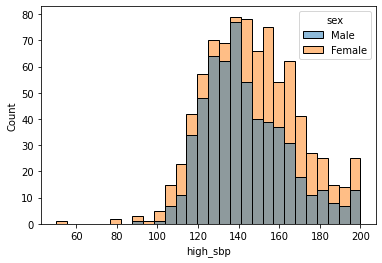

In [62]:
sns.histplot(data=data_all.loc[(data_all.step==0) & (data_all.age_start == 80)], x='high_sbp', hue='sex')

<AxesSubplot:xlabel='high_sbp', ylabel='Count'>

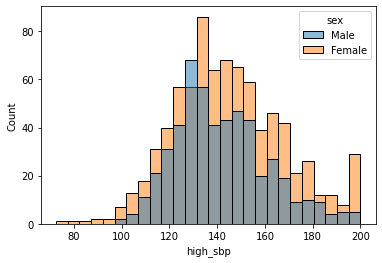

In [63]:
sns.histplot(data=data_all.loc[(data_all.step==74) & (data_all.age_start == 80)], x='high_sbp', hue='sex')

<AxesSubplot:xlabel='sbp_propensity', ylabel='Count'>

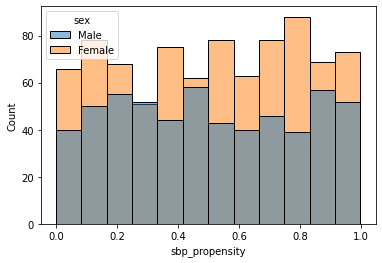

In [66]:
sns.histplot(data=data_all.loc[(data_all.step==0) & (data_all.age_start == 80)], x='sbp_propensity', hue='sex')

<AxesSubplot:xlabel='sbp_propensity', ylabel='Count'>

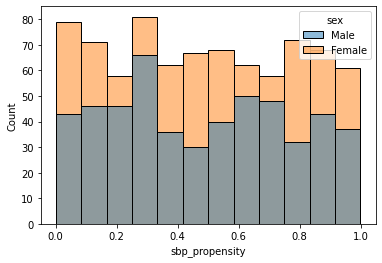

In [65]:
sns.histplot(data=data_all.loc[(data_all.step==74) & (data_all.age_start == 80)], x='sbp_propensity', hue='sex')

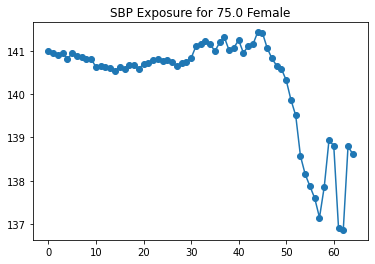

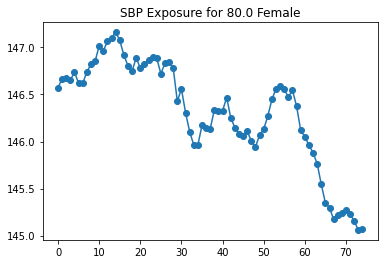

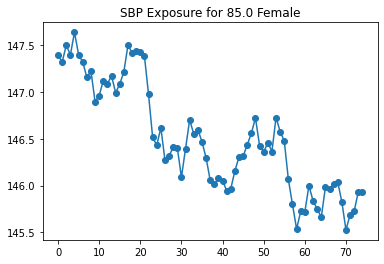

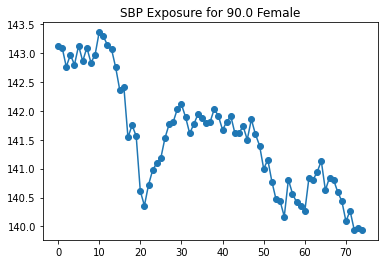

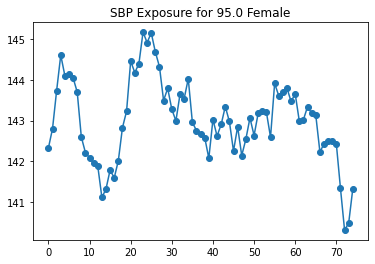

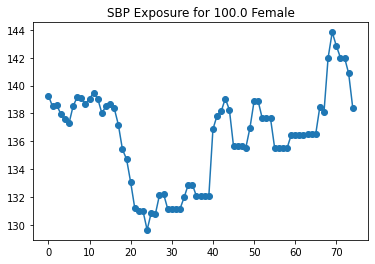

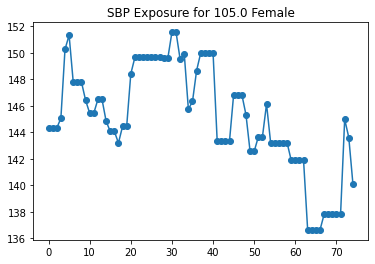

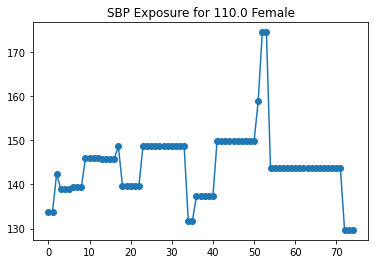

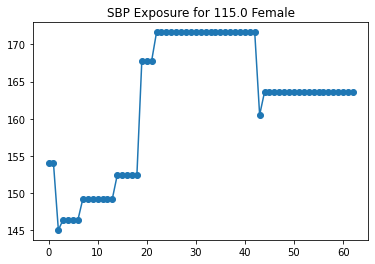

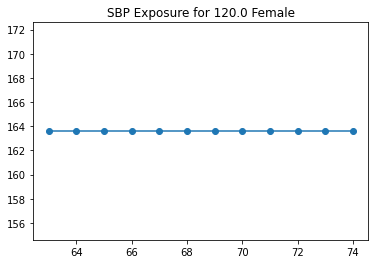

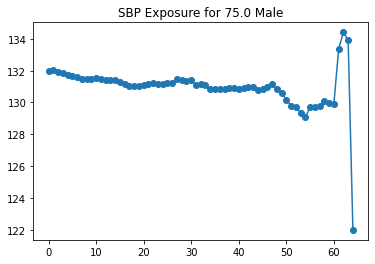

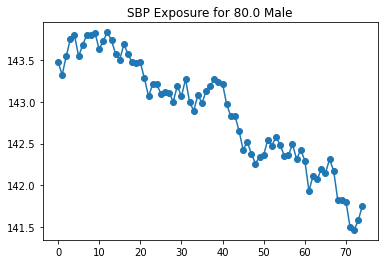

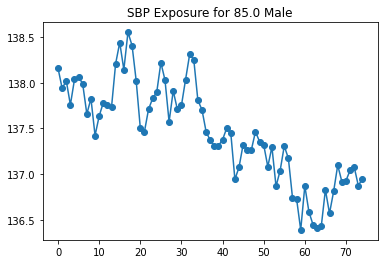

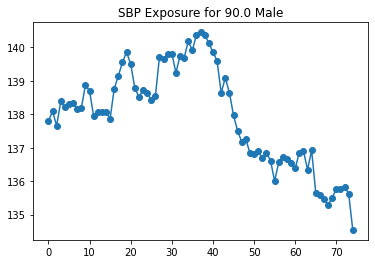

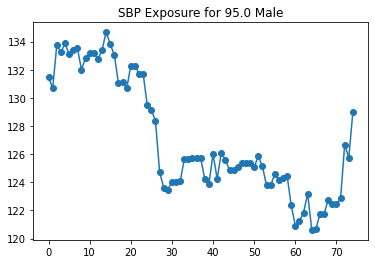

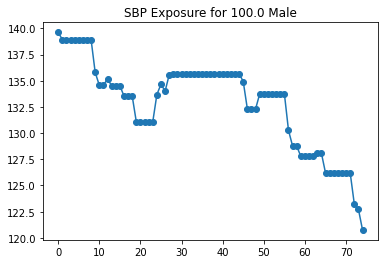

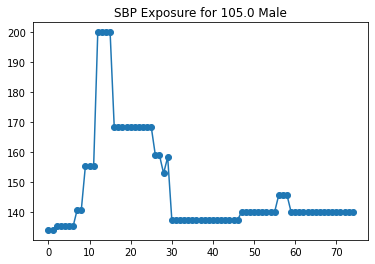

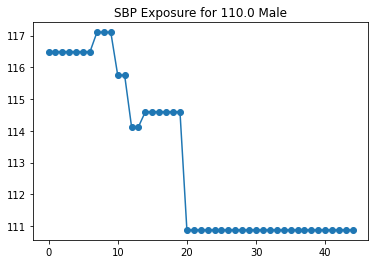

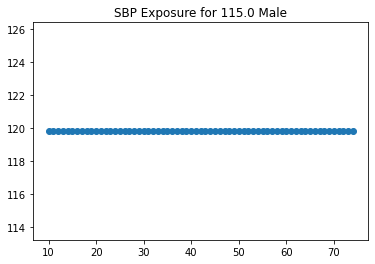

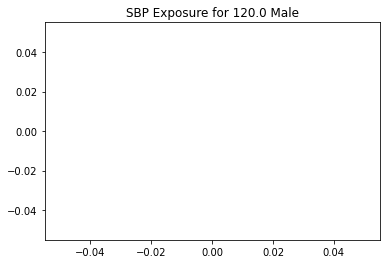

In [61]:
for sex in sbp.sex.unique():
    for age in sbp.age_start.unique():
        plt.figure()
        subdata = sbp.loc[(sbp.age_start == age) & (sbp.sex == sex)]
        plt.plot(subdata['step'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['step'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure for {age} {sex}')
        #plt.ylim(135,150)

In [111]:
HF_regression = data_all[['age_start','sex','high_sbp','high_bmi','high_ldl','high_fpg','heart_failure_from_ischemic_heart_disease_event_count','heart_failure_residual_event_count']]
HF_regression['bmi_exposure'] = np.where(HF_regression.high_bmi < 22.5, 0, (HF_regression.high_bmi - 22.5))
HF_regression['sbp_exposure'] = np.where(HF_regression.high_sbp < 120, 0, (HF_regression.high_sbp - 120)/10)
HF_regression['hf_both'] = HF_regression.heart_failure_from_ischemic_heart_disease_event_count + HF_regression.heart_failure_residual_event_count
HF_regression['hf_both_binary'] = np.where(HF_regression.hf_both > 0, 1, 0)
HF_regression['hf_ihd_binary'] = np.where(HF_regression.heart_failure_from_ischemic_heart_disease_event_count > 0, 1, 0)
HF_regression.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,high_fpg,heart_failure_from_ischemic_heart_disease_event_count,heart_failure_residual_event_count,bmi_exposure,sbp_exposure,hf_both,hf_both_binary,hf_ihd_binary
0,45.0,Female,127.134134,24.802611,2.644998,6.138124,0,0,2.302611,0.713413,0,0,0
1,40.0,Male,131.808766,27.165902,3.376564,4.975500,0,0,4.665902,1.180877,0,0,0
2,50.0,Female,106.466069,33.998750,2.074324,7.768995,0,0,11.498750,0.000000,0,0,0
3,30.0,Male,109.868926,27.233734,3.756715,5.494943,0,0,4.733734,0.000000,0,0,0
6,30.0,Male,132.593806,24.365348,1.946794,5.426104,0,0,1.865348,1.259381,0,0,0


In [112]:
HF_regression.loc[HF_regression['hf_ihd_binary'] > 0]
HF_regression_small = HF_regression.loc[HF_regression.high_bmi < 37]
HF_regression_small.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,high_fpg,heart_failure_from_ischemic_heart_disease_event_count,heart_failure_residual_event_count,bmi_exposure,sbp_exposure,hf_both,hf_both_binary,hf_ihd_binary
0,45.0,Female,127.134134,24.802611,2.644998,6.138124,0,0,2.302611,0.713413,0,0,0
1,40.0,Male,131.808766,27.165902,3.376564,4.975500,0,0,4.665902,1.180877,0,0,0
2,50.0,Female,106.466069,33.998750,2.074324,7.768995,0,0,11.498750,0.000000,0,0,0
3,30.0,Male,109.868926,27.233734,3.756715,5.494943,0,0,4.733734,0.000000,0,0,0
6,30.0,Male,132.593806,24.365348,1.946794,5.426104,0,0,1.865348,1.259381,0,0,0


In [113]:
model = smf.logit("hf_ihd_binary ~ bmi_exposure", data = HF_regression_small).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='bmi_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

Optimization terminated successfully.
         Current function value: 0.022543
         Iterations 10


,coeff,rr
bmi_exposure,-0.046806,0.954273


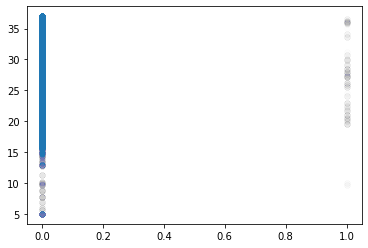

In [120]:
plt.scatter(HF_regression_small.hf_ihd_binary, HF_regression_small.high_bmi, alpha=0.004)

In [77]:
model = smf.logit("hf_ihd_binary ~ sbp_exposure", data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

Optimization terminated successfully.
         Current function value: 0.057750
         Iterations 9


,coeff,rr
sbp_exposure,0.292618,1.339931


In [55]:
data_all.sbp_medication.unique()

array(['no_treatment', 'one_drug_half_dose_efficacy',
       'two_drug_half_dose_efficacy', 'two_drug_std_dose_efficacy',
       'one_drug_std_dose_efficacy', 'three_drug_half_dose_efficacy',
       'three_drug_std_dose_efficacy'], dtype=object)

(array([3., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 2., 1., 1., 0., 1.,
        1., 1., 1.]),
 array([0.00817929, 0.05177132, 0.09536336, 0.13895539, 0.18254742,
        0.22613945, 0.26973148, 0.31332351, 0.35691555, 0.40050758,
        0.44409961, 0.48769164, 0.53128367, 0.5748757 , 0.61846774,
        0.66205977, 0.7056518 , 0.74924383, 0.79283586, 0.83642789,
        0.88001993]),
 <BarContainer object of 20 artists>)

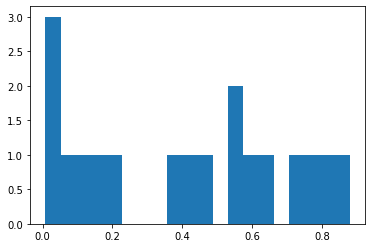

In [75]:
plt.hist(data_all.loc[(data_all.age_start == 95) & (data_all.step == 1) & (data_all.alive == 'alive')].bmi_propensity, bins=20)

In [76]:
data_all.loc[(data_all.age_start == 50) & (data_all.step == 1) & (data_all.alive == 'alive')].bmi_propensity.median()

0.49845948250807587

(array([2., 0., 0., 3., 1., 1., 3., 1., 1., 0., 3., 0., 3., 1., 1., 1., 1.,
        0., 0., 1.]),
 array([0.00228378, 0.04707281, 0.09186183, 0.13665086, 0.18143989,
        0.22622892, 0.27101794, 0.31580697, 0.360596  , 0.40538503,
        0.45017405, 0.49496308, 0.53975211, 0.58454114, 0.62933016,
        0.67411919, 0.71890822, 0.76369725, 0.80848627, 0.8532753 ,
        0.89806433]),
 <BarContainer object of 20 artists>)

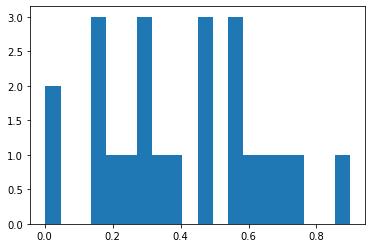

In [77]:
plt.hist(data_all.loc[(data_all.age_start == 95) & (data_all.step == 99) & (data_all.alive == 'alive')].bmi_propensity, bins=20)

In [78]:
data_all.loc[(data_all.age_start == 50) & (data_all.step == 99) & (data_all.alive == 'alive')].bmi_propensity.median()

0.5102848120419113

In [121]:
line = data_all.loc[(data_all.age_start > 60) & (data_all.alive == 'alive')].groupby('step').bmi_propensity.describe(percentiles=[.025,0.25,0.5,0.75,.95]).filter(['mean','2.5%','25%','50%','75%','95%']).reset_index()
line

,step,mean,2.5%,25%,50%,75%,95%
0,0,0.507292,0.024814,0.266476,0.515382,0.752375,0.950489
1,1,0.507713,0.024975,0.266621,0.515135,0.754146,0.950610
2,2,0.507804,0.024998,0.266476,0.515851,0.753833,0.950190
3,3,0.507410,0.025740,0.266553,0.514887,0.751991,0.949283
4,4,0.506138,0.025159,0.266221,0.512942,0.748818,0.948683
...,...,...,...,...,...,...,...
95,95,0.492090,0.022815,0.257484,0.488535,0.734856,0.943448
96,96,0.491069,0.022937,0.255661,0.485545,0.732687,0.943179
97,97,0.490853,0.022924,0.255087,0.485539,0.732479,0.943206
98,98,0.490562,0.022990,0.254634,0.485539,0.732061,0.942979


Text(0, 0.5, 'BMI Propensity 95%')

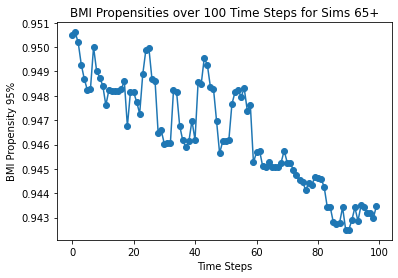

In [122]:
plt.plot(line['step'], line['95%'], marker='o')
#plt.fill_between(line['step'], line['25%'], line['75%'], alpha=.3)
plt.title('BMI Propensities over 100 Time Steps for Sims 65+')
plt.xlabel('Time Steps')
#plt.ylim(0,1)
plt.ylabel('BMI Propensity 95%')

In [ ]:
##Make a historgram of the propensities of the living simulations 

(array([34., 44., 36., 28., 38., 42., 23., 38., 40., 37., 40., 35., 47.,
        40., 30., 32., 35., 55., 33., 34.]),
 array([0.00130343, 0.05113439, 0.10096534, 0.1507963 , 0.20062725,
        0.25045821, 0.30028917, 0.35012012, 0.39995108, 0.44978203,
        0.49961299, 0.54944395, 0.5992749 , 0.64910586, 0.69893682,
        0.74876777, 0.79859873, 0.84842968, 0.89826064, 0.9480916 ,
        0.99792255]),
 <BarContainer object of 20 artists>)

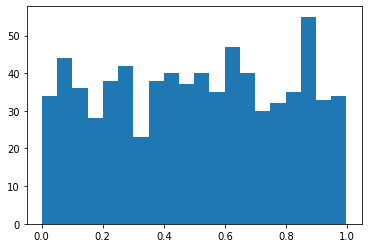

In [73]:
plt.hist(data_all.loc[(data_all.age_start == 25) & (data_all.step == 1) & (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([40., 36., 39., 29., 33., 27., 38., 29., 39., 35., 27., 36., 29.,
        35., 36., 47., 35., 45., 26., 32.]),
 array([2.98632678e-04, 5.01426944e-02, 9.99867561e-02, 1.49830818e-01,
        1.99674879e-01, 2.49518941e-01, 2.99363003e-01, 3.49207065e-01,
        3.99051126e-01, 4.48895188e-01, 4.98739250e-01, 5.48583311e-01,
        5.98427373e-01, 6.48271435e-01, 6.98115496e-01, 7.47959558e-01,
        7.97803620e-01, 8.47647681e-01, 8.97491743e-01, 9.47335805e-01,
        9.97179866e-01]),
 <BarContainer object of 20 artists>)

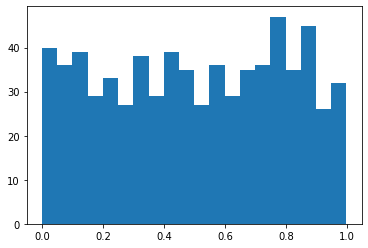

In [74]:
plt.hist(data_all.loc[(data_all.age_start == 25) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([24., 13., 18., 17., 24., 25., 18., 17., 24., 20., 18., 26., 22.,
        16., 19., 19., 17., 31., 14., 17.]),
 array([0.00237308, 0.05206957, 0.10176606, 0.15146255, 0.20115905,
        0.25085554, 0.30055203, 0.35024852, 0.39994501, 0.4496415 ,
        0.49933799, 0.54903448, 0.59873098, 0.64842747, 0.69812396,
        0.74782045, 0.79751694, 0.84721343, 0.89690992, 0.94660641,
        0.99630291]),
 <BarContainer object of 20 artists>)

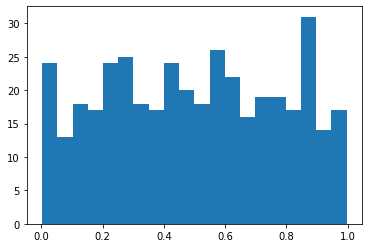

In [75]:
plt.hist(data_all.loc[(data_all.age_start > 75) & (data_all.step == 1) & (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([34., 26., 19., 31., 35., 25., 22., 26., 29., 26., 32., 31., 42.,
        28., 25., 27., 24., 34., 24., 24.]),
 array([0.00237308, 0.05225007, 0.10212706, 0.15200405, 0.20188105,
        0.25175804, 0.30163503, 0.35151202, 0.40138901, 0.451266  ,
        0.50114299, 0.55101998, 0.60089697, 0.65077396, 0.70065095,
        0.75052795, 0.80040494, 0.85028193, 0.90015892, 0.95003591,
        0.9999129 ]),
 <BarContainer object of 20 artists>)

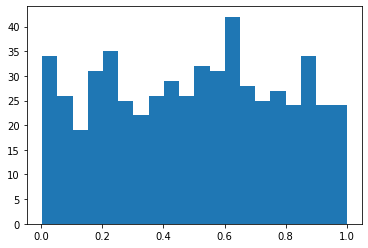

In [76]:
plt.hist(data_all.loc[(data_all.age_start > 75) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity, bins=20)

In [78]:
data_all.loc[(data_all.age_start > 75) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity.mean()

0.49989823405818967

In [85]:
data_all.alive.value_counts()

alive    766284
Name: alive, dtype: int64

In [131]:
line = data_all.loc[(data_all.age_start > 60) & (data_all.alive == 'alive')].groupby('step').high_fasting_plasma_glucose_propensity.median().reset_index()
line

,step,high_fasting_plasma_glucose_propensity
0,0,0.499805
1,1,0.500048
2,2,0.500290
3,3,0.499805
4,4,0.498969
...,...,...
95,95,0.489306
96,96,0.488742
97,97,0.489120
98,98,0.489500


Text(0, 0.5, 'FPG Propensity Median')

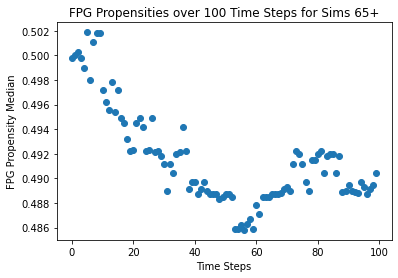

In [132]:
plt.scatter(line.step, line.high_fasting_plasma_glucose_propensity)
plt.title('FPG Propensities over 100 Time Steps for Sims 65+')
plt.xlabel('Time Steps')
plt.ylabel('FPG Propensity Median')

(array([2270.,    0.,  982.,    0.,    0., 1427.,    0.,  171.,    0.,
         126.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

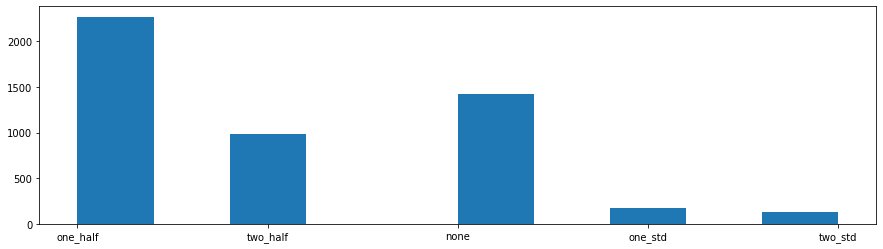

In [21]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 0].sbp_med_short)

(array([2115.,  922.,    0.,  334.,    0.,  878.,  341.,    0.,  180.,
          64.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

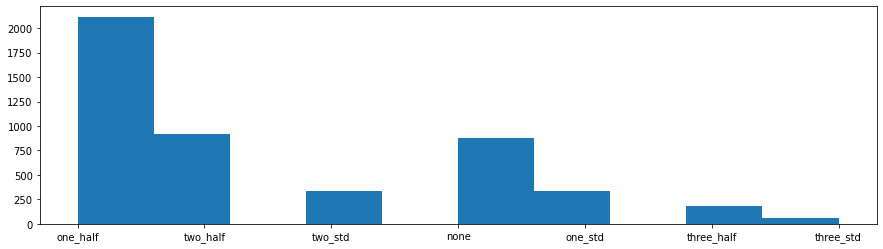

In [22]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 5].sbp_med_short)

(array([1812.,  666.,    0.,  264.,    0.,  243.,  111.,    0.,  724.,
         519.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

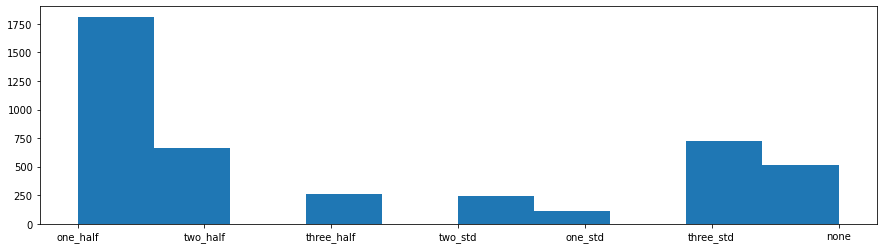

In [23]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 23].sbp_med_short)

In [20]:
meds = (data_all
                .groupby(['step', 'sbp_med_short'])
                .alive.count()
                .reset_index())
meds

,step,sbp_med_short,alive
0,0,none,1427
1,0,one_half,2270
2,0,one_std,171
3,0,two_half,982
4,0,two_std,126
...,...,...,...
160,23,one_std,111
161,23,three_half,264
162,23,three_std,724
163,23,two_half,666


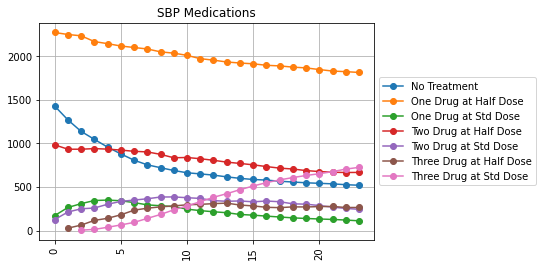

In [24]:
no_trt = meds.loc[(meds.sbp_med_short=='none')]
plt.plot(no_trt['step'], no_trt['alive'], marker='o')
one_half = meds.loc[(meds.sbp_med_short=='one_half')]
plt.plot(one_half['step'], one_half['alive'], marker='o')
one_std = meds.loc[(meds.sbp_med_short=='one_std')]
plt.plot(one_std['step'], one_std['alive'], marker='o')
two_half = meds.loc[(meds.sbp_med_short=='two_half')]
plt.plot(two_half['step'], two_half['alive'], marker='o')
two_std = meds.loc[(meds.sbp_med_short=='two_std')]
plt.plot(two_std['step'], two_std['alive'], marker='o')
three_half = meds.loc[(meds.sbp_med_short=='three_half')]
plt.plot(three_half['step'], three_half['alive'], marker='o')
three_std = meds.loc[(meds.sbp_med_short=='three_std')]
plt.plot(three_std['step'], three_std['alive'], marker='o')
plt.title(f'SBP Medications') 
plt.xticks(rotation=90)
plt.legend(['No Treatment', 'One Drug at Half Dose', 'One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose', 'Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

(array([168.,   0.,  31.,   0.,  90.,   0.,  91.,   0.,  15.,   4.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

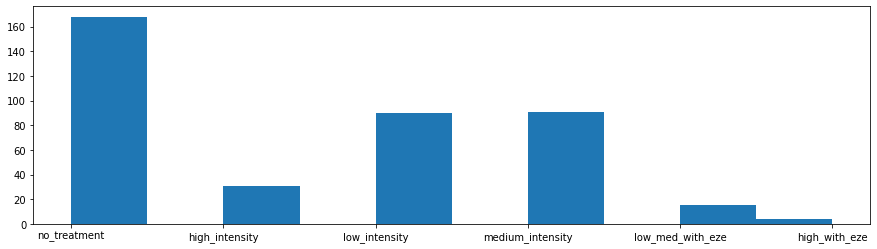

In [74]:
plt.figure(figsize=(15,4))
plt.hist(data_all[(data_all.step == 0) & (data_all.age_start > 75)].ldlc_medication)

(array([831.,   0., 350.,   0., 180.,   0., 202.,   0., 303.,  96.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

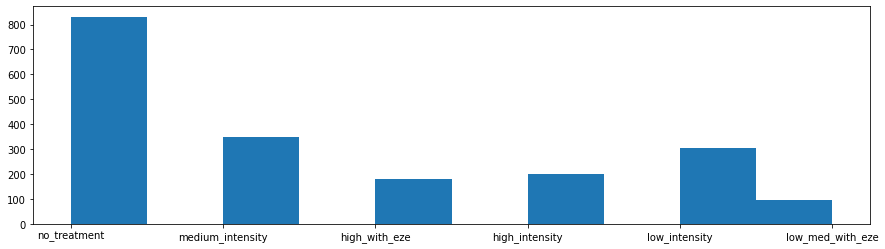

In [48]:
plt.figure(figsize=(15,4))
plt.hist(data_all[(data_all.step == 24) & (data_all.age_start > 60)].ldlc_medication)

In [54]:
ldl_meds = (data_all
                .groupby(['age_start', 'sex', 'step', 'ldlc_medication'])
                .count())
ldl_meds.head()

tracked  exit_time  location  \
age_start sex    step ldlc_medication                                  
25.0      Female 0    high_intensity          5          0         5   
                      low_intensity           6          0         6   
                      medium_intensity       13          0        13   
                      no_treatment          352          0       352   
                 1    high_intensity          5          0         5   

                                        entrance_time  age  alive  \
age_start sex    step ldlc_medication                               
25.0      Female 0    high_intensity                5    5      5   
                      low_intensity                 6    6      6   
                      medium_intensity             13   13     13   
                      no_treatment                352  352    352   
                 1    high_intensity                5    5      5   

                                        years_of_life_lost  cause_of_death  \
age_start sex    step ldlc_medication                                        
25.0      Female 0    high_intensity                     5               5   
                      low_intensity                      6               6   
                      medium_intensity                  13              13   
                      no_treatment                     352             352   
                 1    high_intensity                     5               5   

                                        years_lived_with_disability  \
age_start sex    step ldlc_medication                                 
25.0      Female 0    high_intensity                              5   
                      low_intensity                               6   
                      medium_intensity                           13   
                      no_treatment                              352   
                 1    high_intensity                              5   

                                        previous_ischemic_stroke  ...  \
age_start sex    step ldlc_medication                             ...   
25.0      Female 0    high_intensity                           5  ...   
                      low_intensity                            6  ...   
                      medium_intensity                        13  ...   
                      no_treatment                           352  ...   
                 1    high_intensity                           5  ...   

                                        sbp_multiplier  last_fpg_test_date  \
age_start sex    step ldlc_medication                                        
25.0      Female 0    high_intensity                 5                   0   
                      low_intensity                  6                   0   
                      medium_intensity              13                   0   
                      no_treatment                 352                   0   
                 1    high_intensity                 5                   0   

                                        scheduled_date  visit_type  high_ldl  \
age_start sex    step ldlc_medication                                          
25.0      Female 0    high_intensity                 0           5         5   
                      low_intensity                  0           6         6   
                      medium_intensity               3          13        13   
                      no_treatment                   5         352       352   
                 1    high_intensity                 0           5         5   

                                        high_sbp  high_bmi  high_fpg  \
age_start sex    step ldlc_medication                                  
25.0      Female 0    high_intensity           5         5         5   
                      low_intensity            6         6         6   
                      medium_intensity        13        13        13   
                      no_t

/tmp/ipykernel_923009/1426759024.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


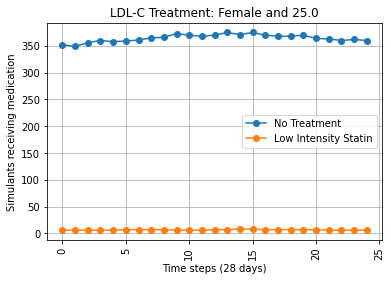

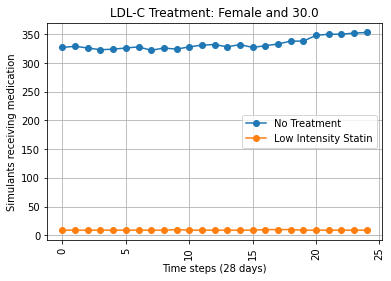

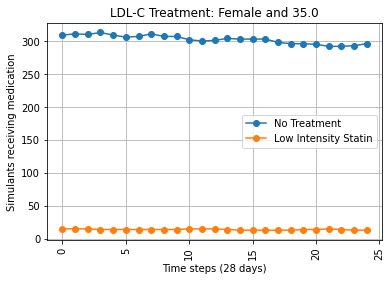

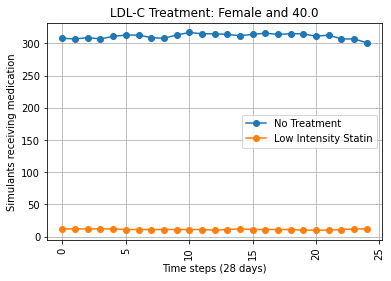

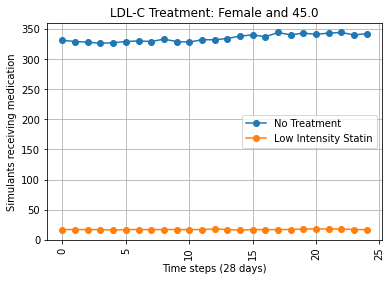

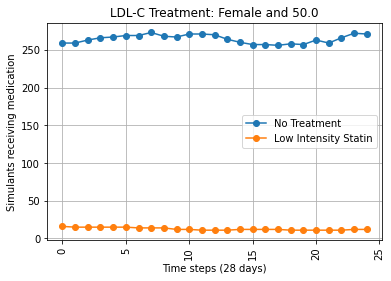

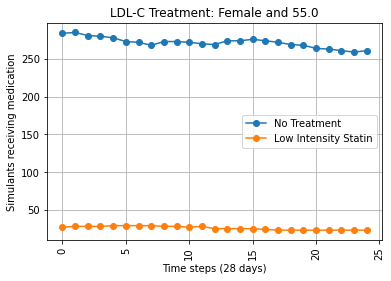

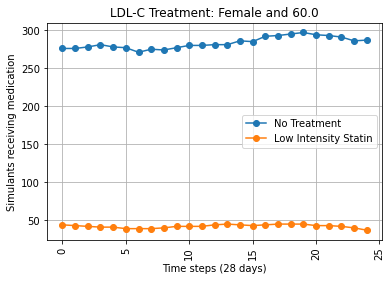

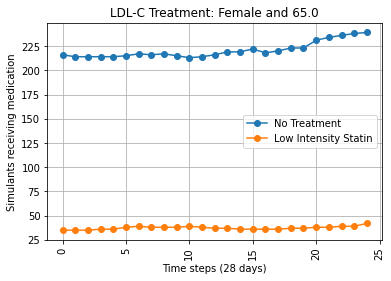

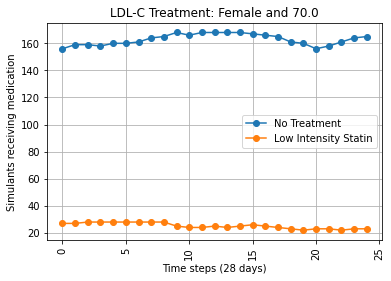

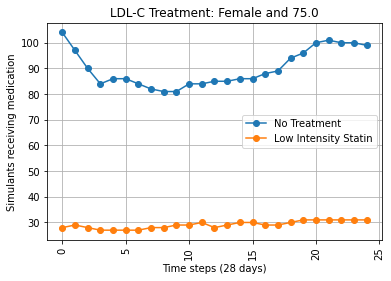

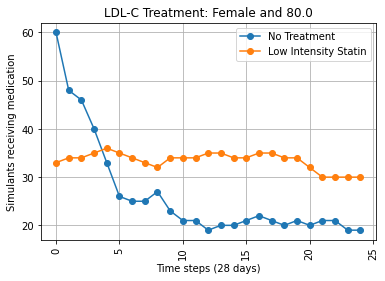

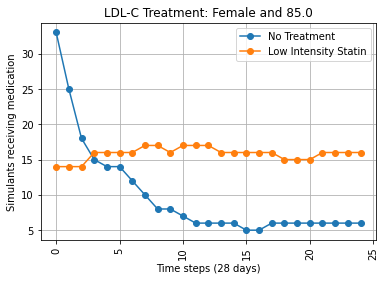

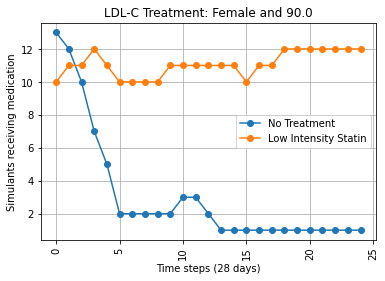

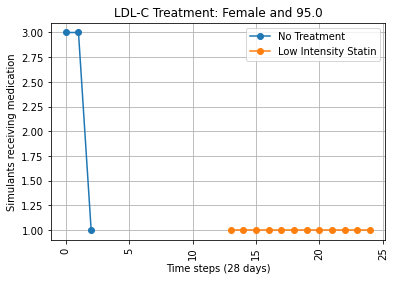

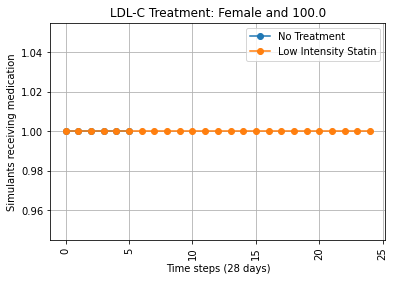

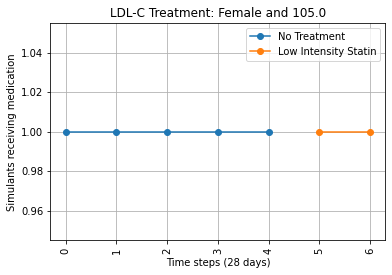

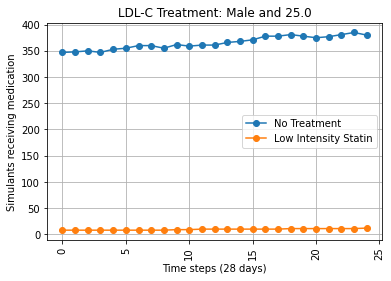

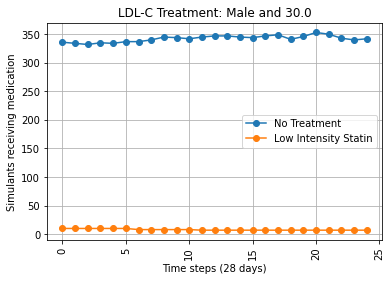

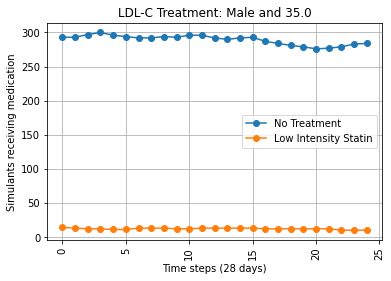

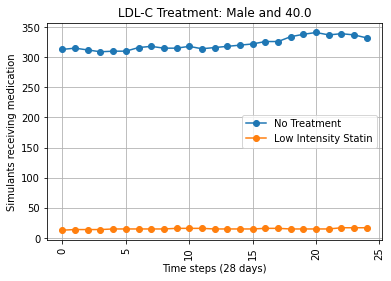

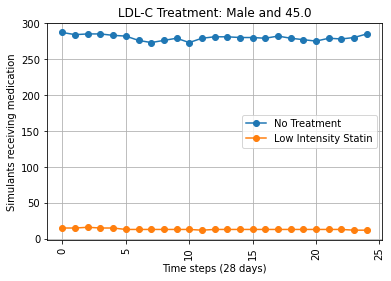

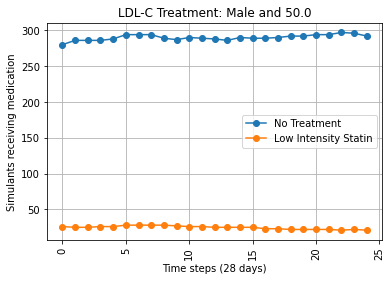

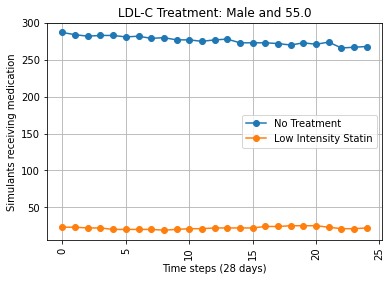

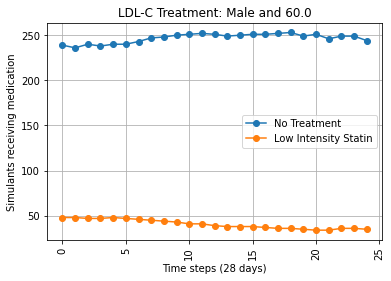

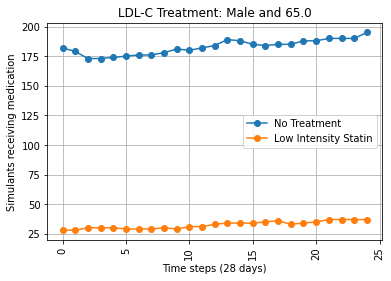

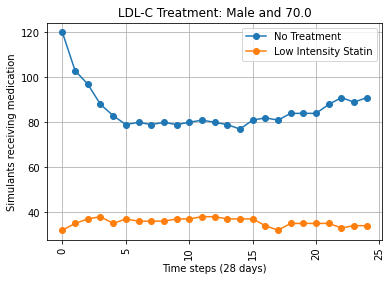

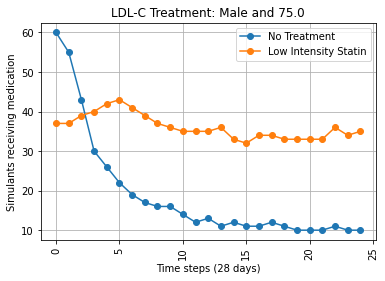

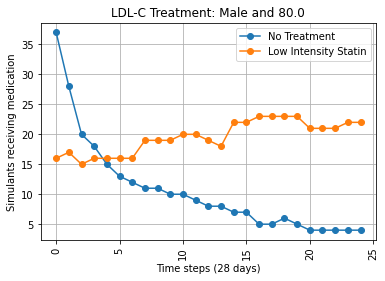

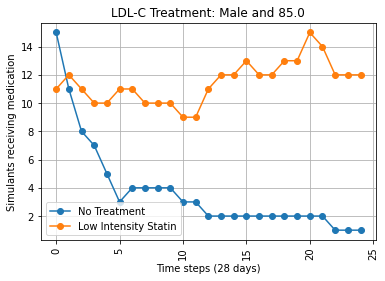

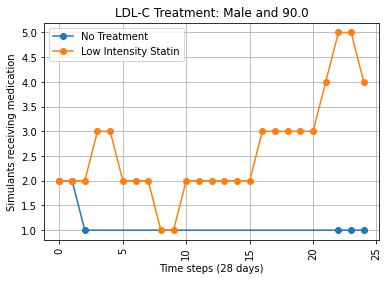

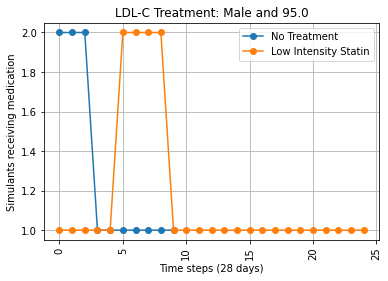

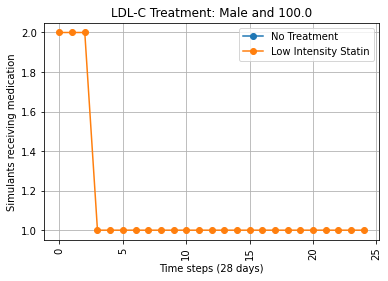

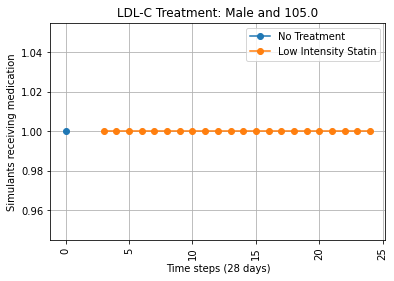

In [73]:
for sex in ldl_meds.index.get_level_values('sex').unique():
    for age in ldl_meds.index.get_level_values('age_start').unique():
        plt.figure() 
        subdata = ldl_meds.loc[(ldl_meds.index.get_level_values('sex')==sex) & (ldl_meds.index.get_level_values('age_start') == age)& (ldl_meds.index.get_level_values('ldlc_medication') == 'no_treatment')]
        plt.plot(subdata.index.get_level_values('step'), subdata['tracked'], marker='o')
        subdata2 = ldl_meds.loc[(ldl_meds.index.get_level_values('sex')==sex) & (ldl_meds.index.get_level_values('age_start') == age)& (ldl_meds.index.get_level_values('ldlc_medication') == 'low_intensity')]
        plt.plot(subdata2.index.get_level_values('step'), subdata2['tracked'], marker='o')
        plt.title(f'LDL-C Treatment: {sex} and {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,150)
        plt.legend(['No Treatment', 'Low Intensity Statin'])
        plt.xlabel('Time steps (28 days)')
        plt.ylabel('Simulants receiving medication')
        plt.grid()


In [48]:
sbp_exp_step = (data_all
                .groupby(['age_start', 'sex', 'step'])
                .high_sbp.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
sbp_exp_step.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,109.763541,94.366671,132.482994
1,25.0,Female,1,109.715144,94.355954,132.272194
2,25.0,Female,2,109.698650,94.388106,132.024395
3,25.0,Female,3,109.772129,94.414899,131.783997
4,25.0,Female,4,109.717781,94.404182,131.884820


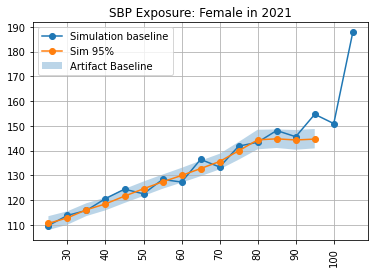

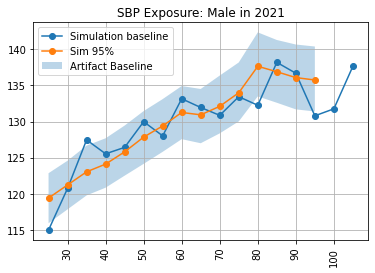

In [49]:
for sex in sbp_exp_step.sex.unique():
    plt.figure() 
    subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.step == 0)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

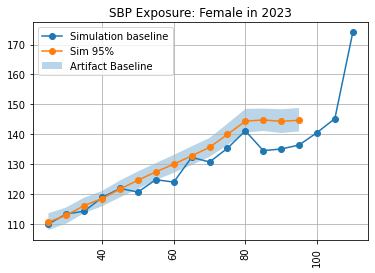

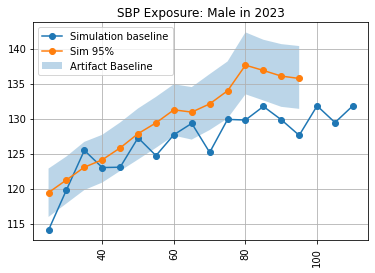

In [50]:
for sex in sbp_exp_step.sex.unique():
    plt.figure() 
    subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.step == 59)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

/tmp/ipykernel_3409029/1562487388.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


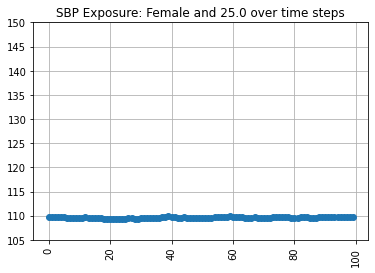

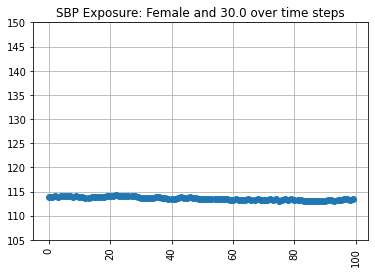

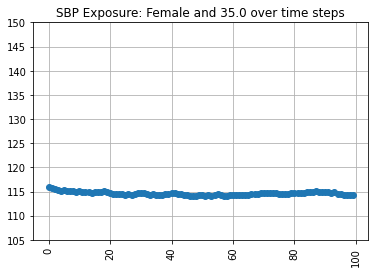

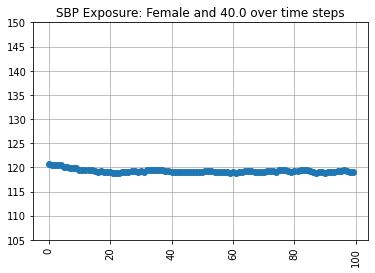

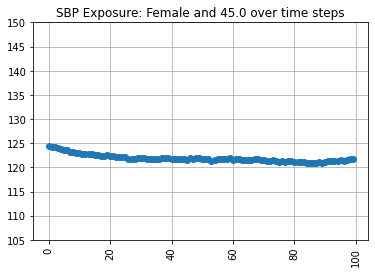

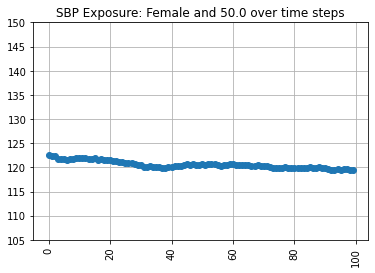

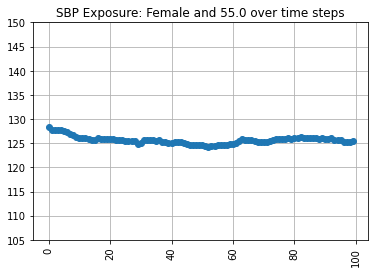

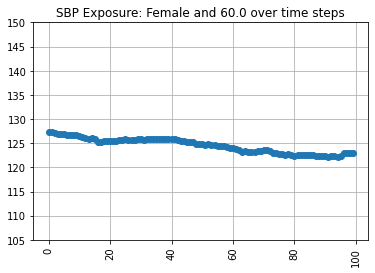

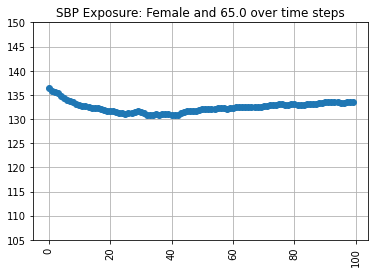

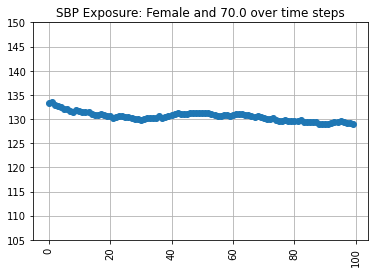

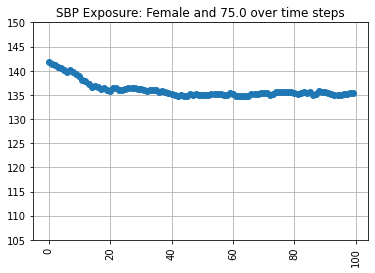

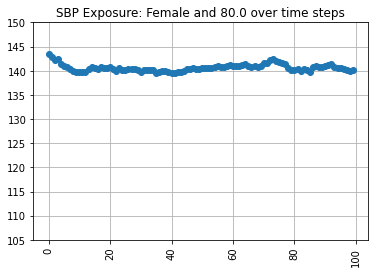

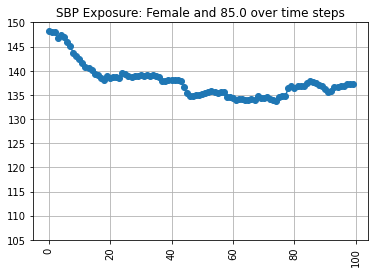

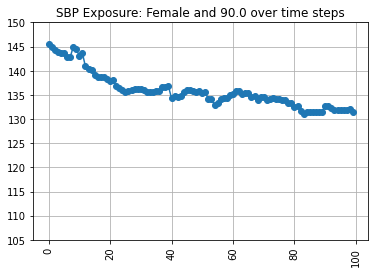

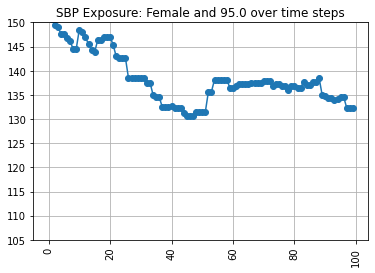

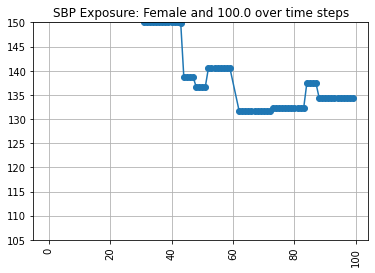

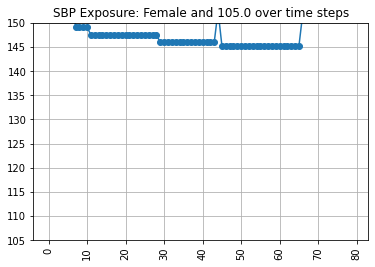

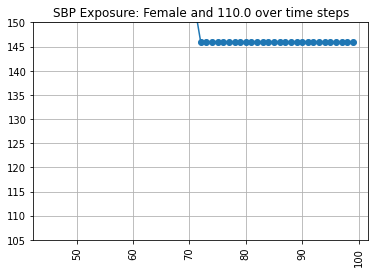

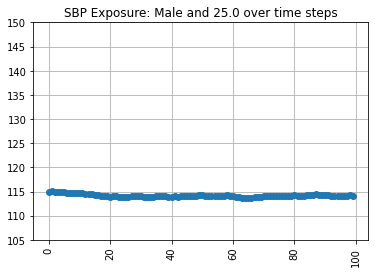

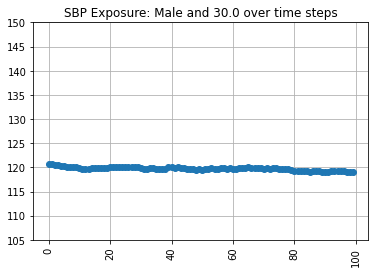

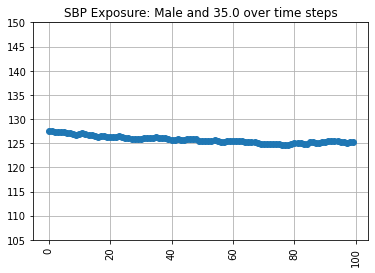

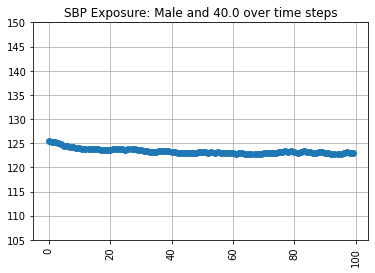

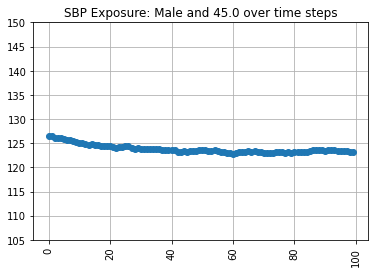

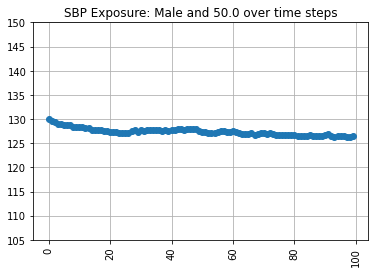

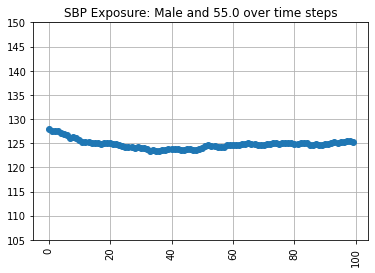

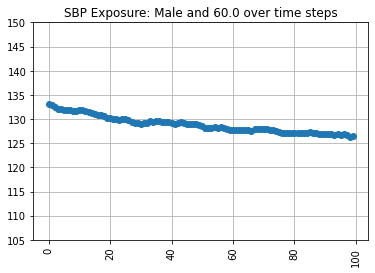

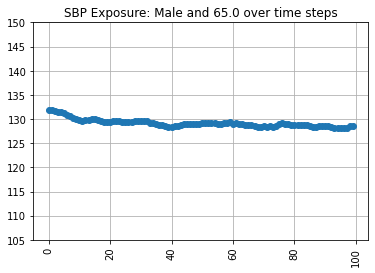

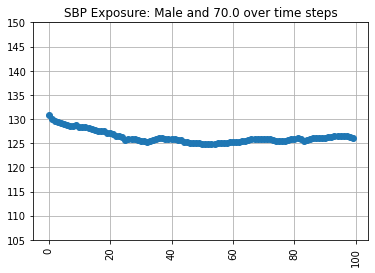

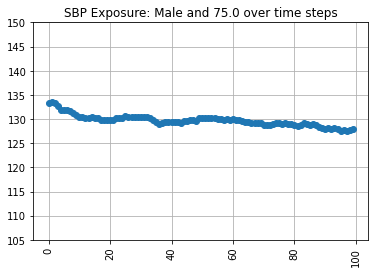

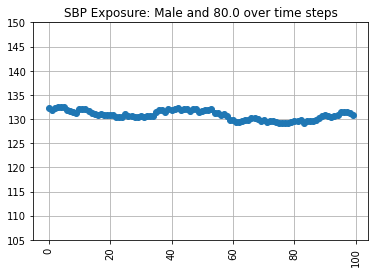

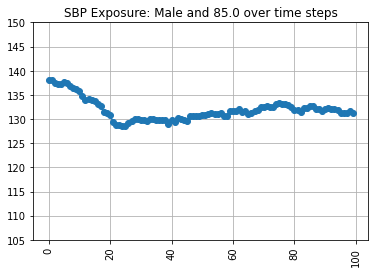

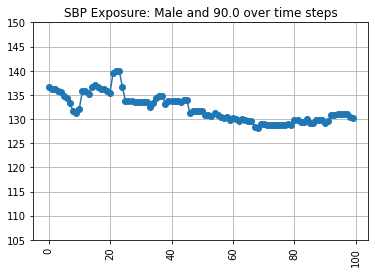

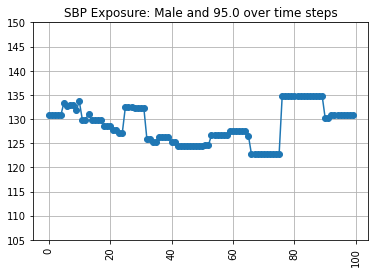

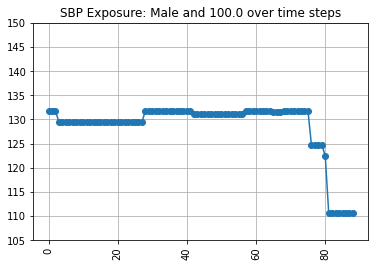

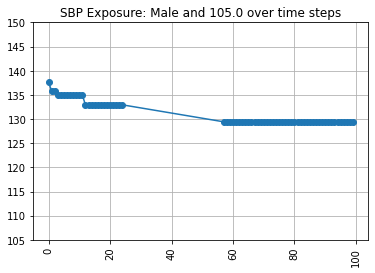

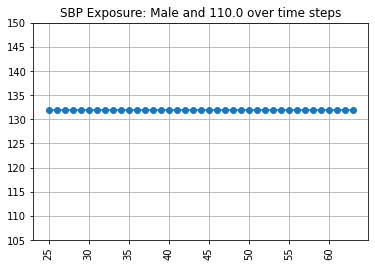

In [51]:
for sex in sbp_exp_step.sex.unique():
    for age in sbp_exp_step.age_start.unique():
        plt.figure() 
        subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.age_start == age)]
        plt.plot(subdata['step'], subdata['mean'], marker='o')
        plt.title(f'SBP Exposure: {sex} and {age} over time steps') 
        plt.xticks(rotation=90) 
        plt.ylim(105, 150)
        plt.grid()

In [52]:
ldl_exp_step = (data_all
                .groupby(['age_start', 'sex', 'step'])
                .high_ldl.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
ldl_exp_step.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,2.614019,1.060160,4.488018
1,25.0,Female,1,2.607706,1.029476,4.489927
2,25.0,Female,2,2.599956,1.010938,4.484201
3,25.0,Female,3,2.596361,0.996157,4.479430
4,25.0,Female,4,2.587963,0.996154,4.481338


In [54]:
%%capture
for sex in ldl_exp_step.sex.unique():
    for age in ldl_exp_step.age_start.unique():
        plt.figure() 
        subdata = ldl_exp_step.loc[(ldl_exp_step.sex==sex) & (ldl_exp_step.age_start == age)]
        plt.plot(subdata['step'], subdata['mean'], marker='o')
        plt.title(f'LDL Exposure: {sex} and {age} over time steps') 
        plt.xticks(rotation=90) 
        plt.ylim(2, 3.5)
        plt.grid()

## Standard Deviation Testing
### For LDL-C First

#### Load in the Artifact

In [55]:
ldl_exp_std = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure_standard_deviation')
ldl_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp_std.age_start,ldl_exp_std.age_end)]
ldl_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.866901,0.810395,0.924996,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,0.834644,0.785313,0.885991,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,0.854927,0.808928,0.901343,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,0.874483,0.826285,0.922943,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,0.900536,0.855616,0.945259,Alabama,exposure_standard_deviation,45_to_49


In [56]:
ldl_std = (data1
                .groupby(['age_start', 'sex'])
                .high_ldl.describe()
                .filter(['std'])
                .reset_index())
ldl_std.head()

,age_start,sex,std
0,25.0,Female,0.895407
1,25.0,Male,0.905610
2,30.0,Female,0.884444
3,30.0,Male,0.890126
4,35.0,Female,0.846148


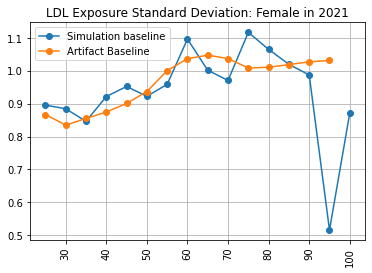

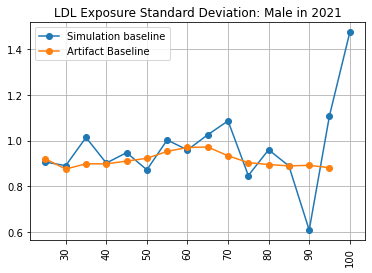

In [57]:
for sex in ldl_std.sex.unique():
    plt.figure() 
    subdata = ldl_std.loc[(ldl_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = ldl_exp_std.loc[(ldl_exp_std.sex==sex) & (ldl_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

The standard deviation looks pretty good here! 

### Now for SBP

In [58]:
sbp_exp_std = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure_standard_deviation')
sbp_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp_std.age_start,sbp_exp_std.age_end)]
sbp_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,10.454106,10.024166,10.880320,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,11.315841,10.866911,11.757483,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,13.122234,12.687791,13.516641,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,14.592419,14.094234,15.091773,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,15.887863,15.414401,16.355687,Alabama,exposure_standard_deviation,45_to_49


In [59]:
sbp_std = (data1
                .groupby(['age_start', 'sex'])
                .high_sbp.describe()
                .filter(['std'])
                .reset_index())
sbp_std.head()

,age_start,sex,std
0,25.0,Female,10.088955
1,25.0,Male,10.188180
2,30.0,Female,11.704081
3,30.0,Male,12.319051
4,35.0,Female,14.304625


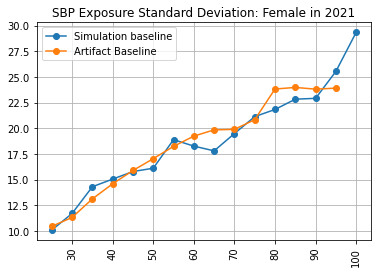

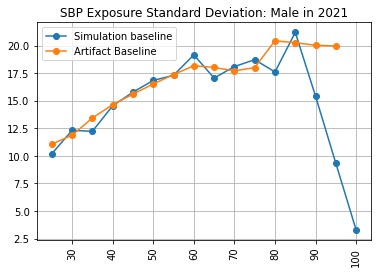

In [60]:
for sex in sbp_std.sex.unique():
    plt.figure() 
    subdata = sbp_std.loc[(sbp_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = sbp_exp_std.loc[(sbp_exp_std.sex==sex) & (sbp_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

A little funky at the start but I would guess this is due to very small numbers at the youngest age groups. Overall this looks fine.

### Lastly, BMI

In [61]:
bmi_exp_std = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure_standard_deviation')
bmi_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_exp_std.age_start,bmi_exp_std.age_end)]
bmi_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,9.300590,8.907572,9.720854,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,9.256498,8.906606,9.615011,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,9.200298,8.854663,9.558446,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,9.153566,8.816779,9.497864,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,8.979148,8.682577,9.302267,Alabama,exposure_standard_deviation,45_to_49


In [62]:
bmi_std = (data1
                .groupby(['age_start', 'sex'])
                .high_bmi.describe()
                .filter(['std'])
                .reset_index())
bmi_std.head()

#Is the orange a mean and the blue a draw? Need to check 

,age_start,sex,std
0,25.0,Female,7.295979
1,25.0,Male,6.259707
2,30.0,Female,6.942931
3,30.0,Male,5.945805
4,35.0,Female,6.505583


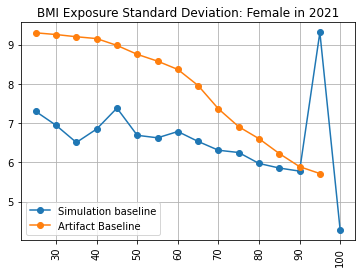

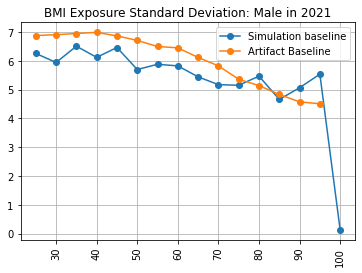

In [63]:
for sex in bmi_std.sex.unique():
    plt.figure() 
    subdata = bmi_std.loc[(bmi_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = bmi_exp_std.loc[(bmi_exp_std.sex==sex) & (bmi_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.title(f'BMI Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Draw 0', 'Draw 1']) 

### FPG Standard Deviation

In [64]:
fpg_exp_std = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure_standard_deviation')
fpg_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_exp_std.age_start,fpg_exp_std.age_end)]
fpg_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,1.192216,0.823940,1.595092,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,1.344822,1.027009,1.703150,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,1.701607,1.352960,2.083557,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,1.985273,1.600582,2.317516,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,1.969448,1.582183,2.352557,Alabama,exposure_standard_deviation,45_to_49


In [65]:
fpg_std = (data1
                .groupby(['age_start', 'sex'])
                .high_fpg.describe()
                .filter(['std'])
                .reset_index())
fpg_std.head()

,age_start,sex,std
0,25.0,Female,1.346607
1,25.0,Male,0.582338
2,30.0,Female,1.038948
3,30.0,Male,1.546426
4,35.0,Female,1.799750


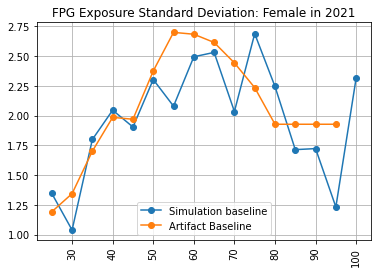

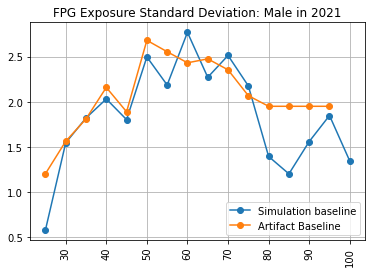

In [66]:
for sex in fpg_std.sex.unique():
    plt.figure() 
    subdata = fpg_std.loc[(fpg_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = fpg_exp_std.loc[(fpg_exp_std.sex==sex) & (fpg_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.title(f'FPG Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

## Relative Risk and PAF Testing 
### Using the regression approach here since we don't have GBD values for RR and PAFs for HF 

Unfortunately that means we have to test single combos of causes and risks. I plan to focus on HF causes which are: HF with IHD and HF residual. Only SBP and BMI have an effect on HF. 

In [23]:
HF_regression = data1[['age_start','sex','high_sbp','high_bmi','high_ldl','hf_ihd','hf_resid','acute_mi']]
HF_regression['bmi_exposure'] = np.where(HF_regression.high_bmi < 22.5, 0, (HF_regression.high_bmi - 22.5))
HF_regression['sbp_exposure'] = np.where(HF_regression.high_sbp < 120, 0, (HF_regression.high_sbp - 120)/10)
HF_regression['hf_sum'] = HF_regression.hf_ihd + HF_regression.hf_resid
HF_regression.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,hf_ihd,hf_resid,acute_mi,bmi_exposure,sbp_exposure,hf_sum
0,45.0,Female,127.134134,24.802611,2.644998,0.000024,0.000063,0.000012,2.302611,0.713413,0.000087
1,40.0,Male,131.808766,27.165902,3.376564,0.000020,0.000056,0.000022,4.665902,1.180877,0.000075
2,50.0,Female,106.466069,33.998750,2.074324,0.000052,0.000096,0.000031,11.498750,0.000000,0.000149
3,30.0,Male,109.868926,27.233734,3.756715,0.000012,0.000055,0.000005,4.733734,0.000000,0.000067
6,30.0,Male,132.593806,24.365348,1.946794,0.000017,0.000075,0.000003,1.865348,1.259381,0.000092


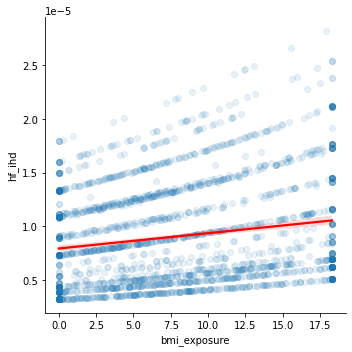

In [47]:
HF_regression_small = HF_regression.loc[(HF_regression.age_start < 40)]
sns.lmplot(x='bmi_exposure',y='hf_ihd',data=HF_regression_small, line_kws={'color': 'red'},scatter_kws={'alpha':0.1})

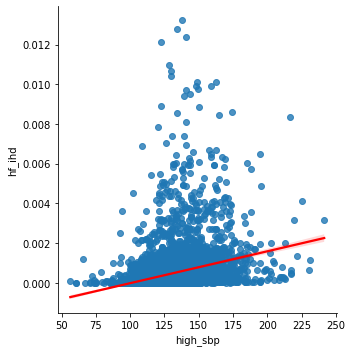

In [25]:
sns.lmplot(x='high_sbp',y='hf_ihd',data=HF_regression, line_kws={'color': 'red'})

In [ ]:
model = smf.logit("hf_ihd ~ bmi_exposure", data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='bmi_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

In [71]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
bmi_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
bmi_rr_hf = bmi_rr.loc[(bmi_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease')| (bmi_rr['affected_entity']=='heart_failure_residual')]
bmi_rr_hf.head()

,affected_entity,mean
3,heart_failure_from_ischemic_heart_disease,1.134219
4,heart_failure_residual,1.134219


In [ ]:
model = smf.logit('hf_resid ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_ihd ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_sum ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
sbp_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
sbp_rr_hf = sbp_rr.loc[(sbp_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease') | (sbp_rr['affected_entity']=='heart_failure_residual')]
sbp_rr_hf.head()

## Checking on the GBD HF Incidence Data

In [ ]:
gbd_hf_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 6,
         metric_id = 3,
         source='epi')

In [ ]:
gbd_hf_inc

In [ ]:
plt.hist(gbd_hf_inc.draw_0, bins=25)

In [ ]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

In [ ]:
data_MI = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','high_fpg','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI.head()

In [ ]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

In [ ]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

In [ ]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

In [ ]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

In [ ]:
art_MI_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_MI_rr_fpg = art_MI_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_MI_rr_fpg = art_MI_rr_fpg.loc[art_MI_rr_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_fpg.head()

In [ ]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

In [ ]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

In [ ]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

In [ ]:
art_MI_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_MI_paf_fpg = art_MI_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_MI_paf_fpg = art_MI_paf_fpg.loc[art_MI_paf_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_fpg.head()

In [ ]:
from get_draws.api import get_draws
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==493]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_MI_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
data_merged.loc[data_merged['inc_i_fpg']>1]

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
#data_merged = data_merged.loc[data_merged['high_bmi']<70]
#data_merged = data_merged.loc[data_merged['high_fpg']<20]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
p.head()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

There are some interesting things here for FPG - seems like a cluster of very high values in 80+ year olds which are leading to strange answers. Need to look into the exposure values further. Also the median is being odd? 

## Same approach for stroke

In [ ]:
data_stroke = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','high_bmi','high_fpg','acute_ischemic_stroke_event_count']]
data_stroke = data_stroke.loc[data_stroke['age_start'] > 20]
data_stroke.head()

In [ ]:
art_stroke_inc = load_artifact_key('cause', 'ischemic_stroke', 'incidence_rate')
art_stroke_inc = art_stroke_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_stroke_inc.head()

In [ ]:
art_stroke_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_stroke_rr_ldl = art_stroke_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_stroke_rr_ldl = art_stroke_rr_ldl.loc[art_stroke_rr_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_ldl.head()

In [ ]:
art_stroke_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_stroke_rr_sbp = art_stroke_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_stroke_rr_sbp = art_stroke_rr_sbp.loc[art_stroke_rr_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_sbp.head()

In [ ]:
art_stroke_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_stroke_rr_bmi = art_stroke_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_stroke_rr_bmi = art_stroke_rr_bmi.loc[art_stroke_rr_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_bmi.head()

In [ ]:
art_stroke_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_stroke_rr_fpg = art_stroke_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_stroke_rr_fpg = art_stroke_rr_fpg.loc[art_stroke_rr_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_fpg.head()

In [ ]:
art_stroke_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_stroke_paf_ldl = art_stroke_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_stroke_paf_ldl = art_stroke_paf_ldl.loc[art_stroke_paf_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_ldl.head()

In [ ]:
art_stroke_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_stroke_paf_sbp = art_stroke_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_stroke_paf_sbp = art_stroke_paf_sbp.loc[art_stroke_paf_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_sbp.head()

In [ ]:
art_stroke_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_stroke_paf_bmi = art_stroke_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_stroke_paf_bmi = art_stroke_paf_bmi.loc[art_stroke_paf_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_bmi.head()

In [ ]:
art_stroke_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_stroke_paf_fpg = art_stroke_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_stroke_paf_fpg = art_stroke_paf_fpg.loc[art_stroke_paf_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_fpg.head()

In [ ]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==495]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==495]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==495]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==495]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_stroke.merge(art_stroke_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_stroke_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_stroke_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_stroke_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_stroke_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_stroke_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_stroke_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_stroke_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_stroke_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

Less here, this matches with what we saw in the other notebook - MI is more worrisome 